In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from model import *
import math
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
pd.options.mode.chained_assignment = None  # default='warn'
import pickle

In [64]:
data = pd.read_csv('metadata.csv')
data

,ID,Class,Path,Band
0,1.3319.10,LPV,1.3319.10.dat,1.0
1,1.3441.15,Cep_0,1.3441.15.dat,1.0
2,1.3441.25,LPV,1.3441.25.dat,1.0
3,1.3441.45,Cep_0,1.3441.45.dat,1.0
4,1.3441.1031,RRab,1.3441.1031.dat,1.0
...,...,...,...,...
21439,9.5608.870,RRab,9.5608.870.dat,1.0
21440,9.5608.946,RRab,9.5608.946.dat,1.0
21441,9.5609.22,EC,9.5609.22.dat,1.0
21442,9.5609.790,RRab,9.5609.790.dat,1.0


In [65]:
df = data[data['Class'] == 'RRab'].reset_index(drop=True)
df

,ID,Class,Path,Band
0,1.3441.1031,RRab,1.3441.1031.dat,1.0
1,1.3442.503,RRab,1.3442.503.dat,1.0
2,1.3442.1051,RRab,1.3442.1051.dat,1.0
3,1.3442.1107,RRab,1.3442.1107.dat,1.0
4,1.3442.1243,RRab,1.3442.1243.dat,1.0
...,...,...,...,...
7392,9.5607.1084,RRab,9.5607.1084.dat,1.0
7393,9.5608.870,RRab,9.5608.870.dat,1.0
7394,9.5608.946,RRab,9.5608.946.dat,1.0
7395,9.5609.790,RRab,9.5609.790.dat,1.0


In [66]:
stars = dict()
availables = list()
tol = 500
for i in range(len(df['Path'])):
  # if i>=tol:
  #     break
  path = df['Path'][i]
  # path_reg = 'RRab_fase_regulares/' + path + '_' + str('regular_phased.pkl')
  path_reg = 'RRab_fase_regulares/' + path + '_' + str('regular_phased.pkl')
  with open(path_reg, 'rb') as file:
    # Llama al método load para deserializar
    datos = pickle.load(file)
  availables.append(path)
  stars[path] = datos

In [67]:
print(len(availables))
df_star = stars['1.3442.1243.dat']
df_star

7397


,phase,mag
0,0.002229,-5.015000
1,0.004635,-5.277673
2,0.007042,-5.230566
3,0.009448,-5.207772
4,0.011854,-4.803603
...,...,...
410,0.988813,-5.130105
411,0.991219,-5.146885
412,0.993625,-4.715542
413,0.996032,-5.053955


DataFrame con RMSE de cada serie vs largo de la serie. Promedio RMSE +- std desv. Matriz de correlación. Promedio (p,d,q) usado.

In [68]:
best_param = dict()
n = len(df['Path'])
# n = 10
sum = 0
d = 0
for i in range(n):
  ## AR Process
  # if i>=tol:
  #     break
  print(i)
  path = df['Path'][i]
  df_star = stars[path]
  n_ = len(df_star)
  if  n_ > 10: #filtro series con muy pocos datos.
    sum += 1
    df_testing = pd.DataFrame((df_star.mag))
    best_p = train_ar(df_star)
    [df_train,df_test,theta,intercept,rmse_ar] = AR(best_p,pd.DataFrame(df_star.mag))
    df_c = pd.concat([df_train,df_test])

    ## MA Process
    res = pd.DataFrame()
    res['Residuals'] = df_c.mag - df_c.Predicted_Values
    best_q = train_ma(res)
    [res_train,res_test,theta,intercept,rmse_ma] = MA(best_q,pd.DataFrame(res.Residuals))
    res_c = pd.concat([res_train,res_test])
    df_c.Predicted_Values += res_c.Predicted_Values
    rmse = rmse_ar + rmse_ma
    best_param[(path, best_p, d, best_q, n_ )] = rmse
  else:
    continue
print('Cantidad de series utilizadas: ', sum)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [69]:
best_param

{('1.3441.1031.dat', 3, 0, 1, 302): 0.3624511969395384,
 ('1.3442.503.dat', 4, 0, 1, 539): 0.15074984434210337,
 ('1.3442.1051.dat', 4, 0, 1, 378): 0.20576150856997216,
 ('1.3442.1107.dat', 1, 0, 1, 395): 0.3061820981882278,
 ('1.3442.1243.dat', 1, 0, 2, 415): 0.24564503287089828,
 ('1.3442.1388.dat', 4, 0, 1, 327): 0.4050729088510696,
 ('1.3443.1313.dat', 1, 0, 1, 418): 0.21728411316529603,
 ('1.3443.1335.dat', 1, 0, 2, 354): 0.3237900397554092,
 ('1.3445.1478.dat', 4, 0, 3, 139): 0.3576997808386757,
 ('1.3446.1877.dat', 4, 0, 4, 770): 0.23219069141743692,
 ('1.3446.1886.dat', 1, 0, 2, 716): 0.43249635846174445,
 ('1.3446.2004.dat', 1, 0, 1, 681): 0.39929699809580654,
 ('1.3449.1212.dat', 1, 0, 1, 791): 0.23945421279991386,
 ('1.3449.1327.dat', 4, 0, 1, 671): 0.5552035530943564,
 ('1.3449.1459.dat', 4, 0, 1, 375): 0.37514995198585793,
 ('1.3562.798.dat', 2, 0, 1, 543): 0.12619584359387315,
 ('1.3562.1159.dat', 1, 0, 1, 359): 0.3339869852670466,
 ('1.3564.981.dat', 2, 0, 1, 505): 0.345

In [70]:
n = len(df['Path'])
table_data = pd.DataFrame()
list_path = []
list_length = []
list_rmse = []
list_p = []
list_d = []
list_q = []

for key, value in best_param.items():
    list_path.append(key[0])
    list_length.append(key[4])
    list_rmse.append(value)
    list_p.append(key[1])
    list_d.append(key[2])
    list_q.append(key[3])

table_data['Path'] = list_path
table_data['Length'] = list_length
table_data['RMSE'] = list_rmse
table_data['p'] = list_p
table_data['d'] = list_d
table_data['q'] = list_q

In [71]:
table_data

,Path,Length,RMSE,p,d,q
0,1.3441.1031.dat,302,0.362451,3,0,1
1,1.3442.503.dat,539,0.150750,4,0,1
2,1.3442.1051.dat,378,0.205762,4,0,1
3,1.3442.1107.dat,395,0.306182,1,0,1
4,1.3442.1243.dat,415,0.245645,1,0,2
...,...,...,...,...,...,...
7386,9.5607.1084.dat,259,1.168912,1,0,1
7387,9.5608.870.dat,308,0.297233,4,0,3
7388,9.5608.946.dat,350,0.453591,4,0,1
7389,9.5609.790.dat,238,0.402039,2,0,2


In [92]:
df_resume = table_data.describe()
df_resume

,Length,RMSE,p,d,q
count,7391.000000,7391.000000,7391.000000,7391.0,7391.000000
mean,496.045867,0.403464,2.587065,0.0,1.773644
std,245.028634,0.272895,1.321608,0.0,1.078659
min,13.000000,0.059715,1.000000,0.0,1.000000
25%,308.500000,0.253587,1.000000,0.0,1.000000
50%,479.000000,0.337882,3.000000,0.0,1.000000
75%,663.000000,0.457214,4.000000,0.0,2.000000
max,1433.000000,3.541694,4.000000,0.0,4.000000


In [94]:
print(df_resume.to_latex(index=True))

\begin{tabular}{lrrrrr}
\toprule
{} &       Length &         RMSE &            p &       d &            q \\
\midrule
count &  7391.000000 &  7391.000000 &  7391.000000 &  7391.0 &  7391.000000 \\
mean  &   496.045867 &     0.403464 &     2.587065 &     0.0 &     1.773644 \\
std   &   245.028634 &     0.272895 &     1.321608 &     0.0 &     1.078659 \\
min   &    13.000000 &     0.059715 &     1.000000 &     0.0 &     1.000000 \\
25\%   &   308.500000 &     0.253587 &     1.000000 &     0.0 &     1.000000 \\
50\%   &   479.000000 &     0.337882 &     3.000000 &     0.0 &     1.000000 \\
75\%   &   663.000000 &     0.457214 &     4.000000 &     0.0 &     2.000000 \\
max   &  1433.000000 &     3.541694 &     4.000000 &     0.0 &     4.000000 \\
\bottomrule
\end{tabular}



/var/folders/k1/rktjz1q15r1c988dv9htps700000gn/T/ipykernel_1497/2194637234.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_resume.to_latex(index=True))


In [73]:
for key, value in best_param.items():
    if value == min(best_param.values()):
        min_value = value
        best_min_star = key
best_min_star

('77.7434.467.dat', 4, 0, 3, 77)

In [74]:
for key, value in best_param.items():
    if value == max(best_param.values()):
        min_value = value
        best_max_star = key
best_max_star

('13.6927.748.dat', 4, 0, 1, 40)

## Time Serie with minimum rmse value

In [75]:
df_star = stars[best_min_star[0]]

In [76]:
[df_train,df_test,theta,intercept,RMSE] = AR(best_min_star[1],pd.DataFrame(df_star.mag))

In [77]:
df_c_min = pd.concat([df_train,df_test])
df_c_min

,mag,Shifted_mag_1,Shifted_mag_2,Shifted_mag_3,Shifted_mag_4,Predicted_Values
4,-5.188175,-5.196795,-5.231197,-5.265598,-5.300000,-5.190206
5,-5.187109,-5.188175,-5.196795,-5.231197,-5.265598,-5.188281
6,-5.186043,-5.187109,-5.188175,-5.196795,-5.231197,-5.178888
7,-5.184977,-5.186043,-5.187109,-5.188175,-5.196795,-5.179129
8,-5.183911,-5.184977,-5.186043,-5.187109,-5.188175,-5.179437
...,...,...,...,...,...,...
72,-5.306285,-5.299815,-5.293345,-5.286875,-5.280404,-5.274281
73,-5.313184,-5.306285,-5.299815,-5.293345,-5.286875,-5.279637
74,-5.321236,-5.313184,-5.306285,-5.299815,-5.293345,-5.285435
75,-5.329287,-5.321236,-5.313184,-5.306285,-5.299815,-5.292166


In [78]:
[res_train,res_test,theta,intercept,RMSE] = MA(best_min_star[3],pd.DataFrame(res.Residuals))

In [79]:
res_c_min = pd.concat([res_train,res_test])
res_c_min

,Residuals,Shifted_values_1,Shifted_values_2,Shifted_values_3,Predicted_Values
7,0.139096,-0.063767,-0.012270,0.002145,0.024383
8,-0.011213,0.139096,-0.063767,-0.012270,-0.011019
9,0.151398,-0.011213,0.139096,-0.063767,0.014956
10,0.132465,0.151398,-0.011213,0.139096,-0.032862
11,0.101777,0.132465,0.151398,-0.011213,-0.019381
...,...,...,...,...,...
63,-0.049454,0.122439,0.118009,0.115770,-0.030332
64,0.332526,-0.049454,0.122439,0.118009,0.002530
65,0.468693,0.332526,-0.049454,0.122439,-0.064386
66,0.581353,0.468693,0.332526,-0.049454,-0.088233


In [80]:
df_c_min.Predicted_Values += res_c_min.Predicted_Values

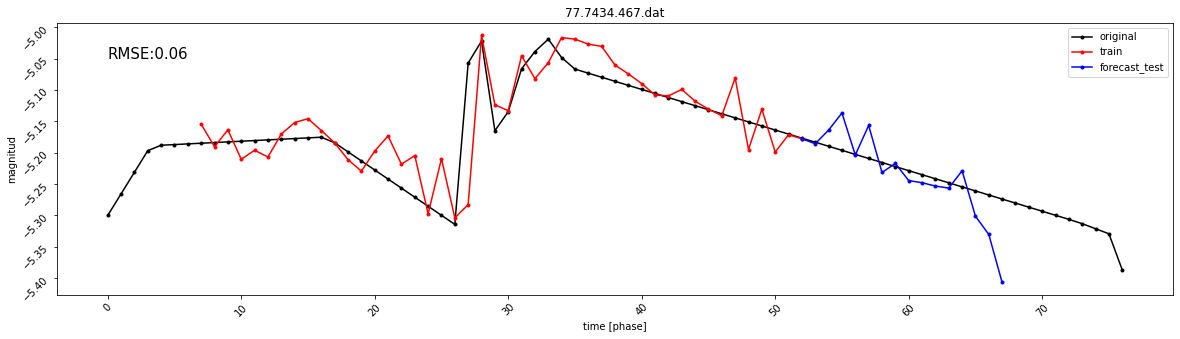

In [81]:
plt.figure(figsize = (20,5))
plt.plot(df_star['mag'], '.-', color = 'black', label = 'original') #.-
plt.plot(df_c_min['Predicted_Values'][:len(df_train['mag'])], '.-', color = 'red', label = 'train') # 
plt.plot(df_c_min['Predicted_Values'][len(df_train['mag'])-1:], '.-', color = 'blue', label = 'forecast_test') #
plt.legend(loc='best')
plt.ylabel('magnitud')
plt.xlabel('time [phase]')
plt.text(0,-5.05, 'RMSE:' + str(round(best_param[best_min_star], 3)), fontsize = 15) #fontsize=18
plt.title(str(best_min_star[0]))
plt.tick_params(labelrotation=45)
plt.text.usetex = True
plt.savefig(fname = 'exampleserie.svg')
plt.show()

## Time Serie with maximum rmse value

In [82]:
df_star = stars[best_max_star[0]]

In [83]:
[df_train,df_test,theta,intercept,RMSE] = AR(best_max_star[1],pd.DataFrame(df_star.mag))

In [84]:
df_c_max = pd.concat([df_train,df_test])
df_c_max

,mag,Shifted_mag_1,Shifted_mag_2,Shifted_mag_3,Shifted_mag_4,Predicted_Values
4,-5.359894,-4.696672,-5.352181,-5.386596,-5.304000,-5.064733
5,-5.262651,-5.359894,-4.696672,-5.352181,-5.386596,-5.263338
6,-5.205681,-5.262651,-5.359894,-4.696672,-5.352181,-5.005490
7,-5.050374,-5.205681,-5.262651,-5.359894,-4.696672,-5.056753
8,-5.188519,-5.050374,-5.205681,-5.262651,-5.359894,-5.131041
9,-5.226224,-5.188519,-5.050374,-5.205681,-5.262651,-5.135445
10,-5.187216,-5.226224,-5.188519,-5.050374,-5.205681,-5.079640
11,-5.393713,-5.187216,-5.226224,-5.188519,-5.050374,-5.076906
12,-5.245636,-5.393713,-5.187216,-5.226224,-5.188519,-5.166815
13,-5.121103,-5.245636,-5.393713,-5.187216,-5.226224,-5.117030


In [85]:
[res_train,res_test,theta,intercept,RMSE] = MA(best_max_star[3],pd.DataFrame(res.Residuals))

In [86]:
res_c_max = pd.concat([res_train,res_test])
res_c_max

,Residuals,Shifted_values_1,Predicted_Values
5,-0.012270,0.002145,0.007929
6,-0.063767,-0.012270,0.010602
7,0.139096,-0.063767,0.020149
8,-0.011213,0.139096,-0.017460
9,0.151398,-0.011213,0.010406
...,...,...,...
63,-0.049454,0.122439,-0.014372
64,0.332526,-0.049454,0.017495
65,0.468693,0.332526,-0.053320
66,0.581353,0.468693,-0.078564


In [87]:
df_c_max.Predicted_Values += res_c_max.Predicted_Values

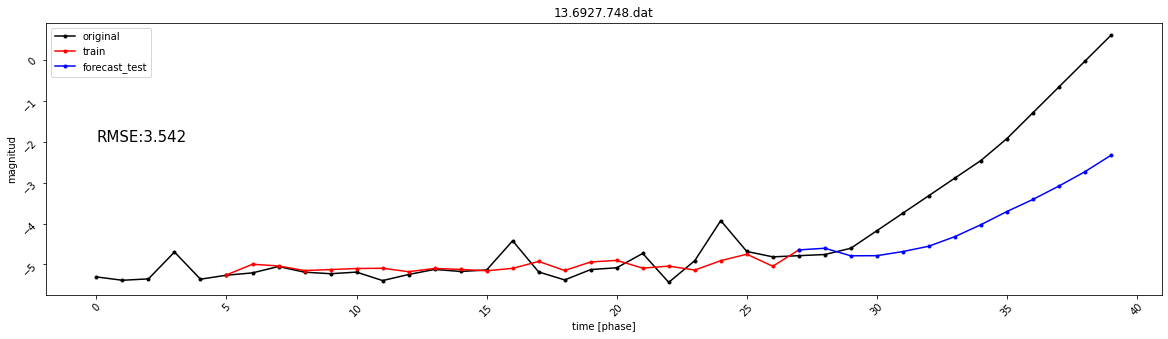

In [90]:
plt.figure(figsize = (20,5))
plt.plot(df_star['mag'], '.-', color = 'black', label = 'original') #.-
plt.plot(df_c_max['Predicted_Values'][:len(df_train['mag'])], '.-', color = 'red', label = 'train') # 
plt.plot(df_c_max['Predicted_Values'][len(df_train['mag'])-1:], '.-', color = 'blue', label = 'forecast_test') #
plt.legend(loc='best')
plt.ylabel('magnitud')
plt.xlabel('time [phase]')
plt.text(0,-2, 'RMSE:' + str(round(best_param[best_max_star], 3)), fontsize = 15)
plt.title(str(best_max_star[0]))
plt.tick_params(labelrotation=45)
plt.text.usetex = True
plt.savefig(fname = 'exampleserie.svg')
plt.show()

#Step 1 : Making the data stationary

Different techniques can be used to make the data stationary, used log and differencing. The additional diff(12) is remove the seasonality.

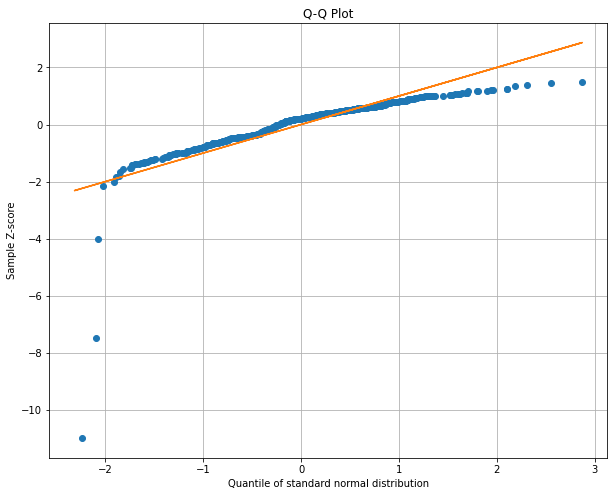

In [48]:
qqplot(df_star['mag'])

In [49]:
df_testing = pd.DataFrame((df_star.mag)) #.diff().diff(12)
df_testing

,mag
0,-0.001990
1,-1.305959
2,-1.072109
3,-0.958954
4,1.047433
...,...
410,-0.573399
411,-0.656696
412,1.484586
413,-0.195370


In [50]:
df_testing.mag

0     -0.001990
1     -1.305959
2     -1.072109
3     -0.958954
4      1.047433
         ...   
410   -0.573399
411   -0.656696
412    1.484586
413   -0.195370
414   -0.279987
Name: mag, Length: 415, dtype: float64

In [51]:
adf_check(df_testing.mag.dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -9.884270629451516
p-value : 3.699628105691139e-17
Number of Lags Used : 0
Number of Observations Used : 414
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


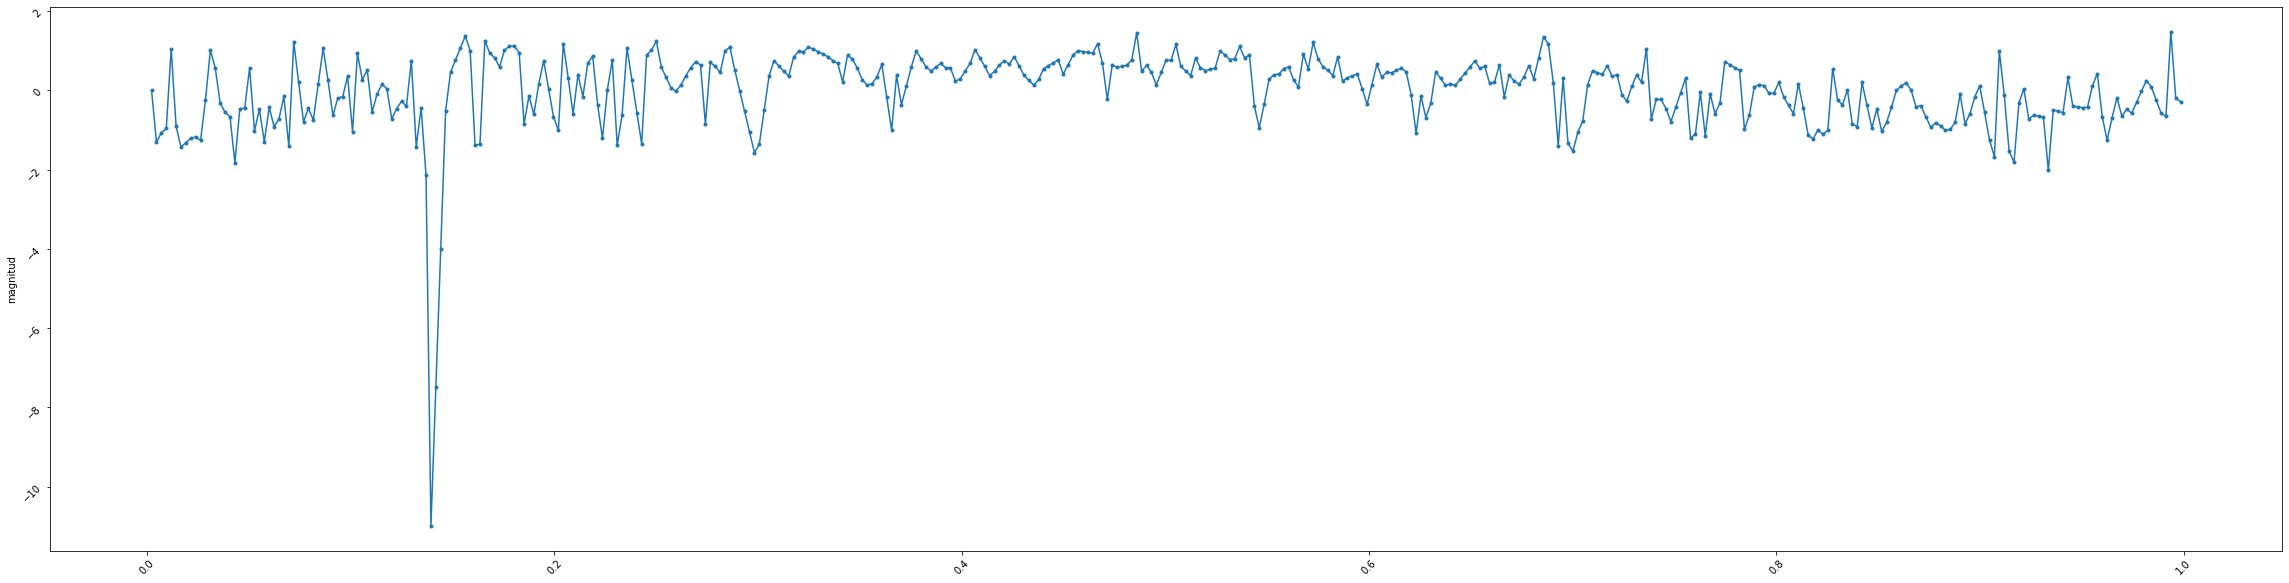

In [52]:
# print(df_testing.to_string())
plot_serie(df_star)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


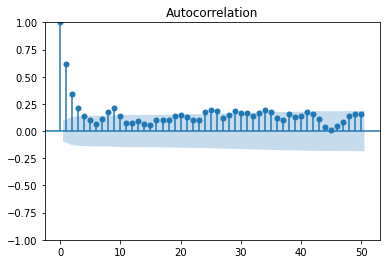

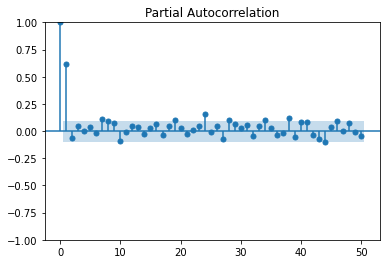

In [53]:
ACF = plot_acf(df_star.mag.dropna(),lags=50)
PACF = plot_pacf(df_star.mag.dropna(),lags=50)

#Step 2 : Fitting AR Model

We calculate the error on the test-set for each p, and pick the best one.

In [54]:
best_p = train_ar(df_star)

The RMSE is : 0.6090711815255473 , Value of p :  1
The RMSE is : 0.6173245172350692 , Value of p :  2
The RMSE is : 0.6166257372428516 , Value of p :  3
The RMSE is : 0.6175080250579044 , Value of p :  4
The RMSE is : 0.613322270248277 , Value of p :  5
The RMSE is : 0.6183828775914909 , Value of p :  6
The RMSE is : 0.6179129695015744 , Value of p :  7
The RMSE is : 0.6097591010614828 , Value of p :  8
The RMSE is : 0.6079803685591753 , Value of p :  9
The RMSE is : 0.6181023010246781 , Value of p :  10
The RMSE is : 0.6241680251840297 , Value of p :  11
The RMSE is : 0.6281267127341615 , Value of p :  12
The RMSE is : 0.6241402929071573 , Value of p :  13
The RMSE is : 0.6320940310229473 , Value of p :  14
The RMSE is : 0.6324585834193786 , Value of p :  15
The RMSE is : 0.6317962144020134 , Value of p :  16
The RMSE is : 0.6352951356712476 , Value of p :  17
The RMSE is : 0.6394094214900111 , Value of p :  18
The RMSE is : 0.6275136732636687 , Value of p :  19
The RMSE is : 0.634652

In [55]:
[df_train,df_test,theta,intercept,RMSE] = AR(best_p,pd.DataFrame(df_star.mag))

The RMSE is : 0.6079803685591753 , Value of p :  9


In [56]:
df_train['mag']

9     -1.177320
10    -1.260046
11    -0.241356
12     1.018784
13     0.559685
         ...   
285    1.167536
286    0.191373
287   -1.392369
288    0.309697
289   -1.331006
Name: mag, Length: 281, dtype: float64

In [57]:
df_test

,mag,Shifted_mag_1,Shifted_mag_2,Shifted_mag_3,Shifted_mag_4,Shifted_mag_5,Shifted_mag_6,Shifted_mag_7,Shifted_mag_8,Shifted_mag_9,Predicted_Values
290,-1.532752,-1.331006,0.309697,-1.392369,0.191373,1.167536,1.353366,0.809325,0.297936,0.625879,-0.897501
291,-1.059655,-1.532752,-1.331006,0.309697,-1.392369,0.191373,1.167536,1.353366,0.809325,0.297936,-0.709277
292,-0.773825,-1.059655,-1.532752,-1.331006,0.309697,-1.392369,0.191373,1.167536,1.353366,0.809325,-0.470742
293,0.134883,-0.773825,-1.059655,-1.532752,-1.331006,0.309697,-1.392369,0.191373,1.167536,1.353366,-0.018377
294,0.499998,0.134883,-0.773825,-1.059655,-1.532752,-1.331006,0.309697,-1.392369,0.191373,1.167536,0.127109
...,...,...,...,...,...,...,...,...,...,...,...
410,-0.573399,-0.240390,0.093698,0.249031,-0.026040,-0.301111,-0.576182,-0.473921,-0.650838,-0.182844,-0.119150
411,-0.656696,-0.573399,-0.240390,0.093698,0.249031,-0.026040,-0.301111,-0.576182,-0.473921,-0.650838,-0.389789
412,1.484586,-0.656696,-0.573399,-0.240390,0.093698,0.249031,-0.026040,-0.301111,-0.576182,-0.473921,-0.390111
413,-0.195370,1.484586,-0.656696,-0.573399,-0.240390,0.093698,0.249031,-0.026040,-0.301111,-0.576182,1.055020


In [58]:
df_c = pd.concat([df_train,df_test])
df_c

,mag,Shifted_mag_1,Shifted_mag_2,Shifted_mag_3,Shifted_mag_4,Shifted_mag_5,Shifted_mag_6,Shifted_mag_7,Shifted_mag_8,Shifted_mag_9,Predicted_Values
9,-1.177320,-1.205536,-1.317988,-1.430439,-0.901864,1.047433,-0.958954,-1.072109,-1.305959,-0.001990,-0.560359
10,-1.260046,-1.177320,-1.205536,-1.317988,-1.430439,-0.901864,1.047433,-0.958954,-1.072109,-1.305959,-0.960841
11,-0.241356,-1.260046,-1.177320,-1.205536,-1.317988,-1.430439,-0.901864,1.047433,-0.958954,-1.072109,-0.617183
12,1.018784,-0.241356,-1.260046,-1.177320,-1.205536,-1.317988,-1.430439,-0.901864,1.047433,-0.958954,-0.011711
13,0.559685,1.018784,-0.241356,-1.260046,-1.177320,-1.205536,-1.317988,-1.430439,-0.901864,1.047433,0.812605
...,...,...,...,...,...,...,...,...,...,...,...
410,-0.573399,-0.240390,0.093698,0.249031,-0.026040,-0.301111,-0.576182,-0.473921,-0.650838,-0.182844,-0.119150
411,-0.656696,-0.573399,-0.240390,0.093698,0.249031,-0.026040,-0.301111,-0.576182,-0.473921,-0.650838,-0.389789
412,1.484586,-0.656696,-0.573399,-0.240390,0.093698,0.249031,-0.026040,-0.301111,-0.576182,-0.473921,-0.390111
413,-0.195370,1.484586,-0.656696,-0.573399,-0.240390,0.093698,0.249031,-0.026040,-0.301111,-0.576182,1.055020


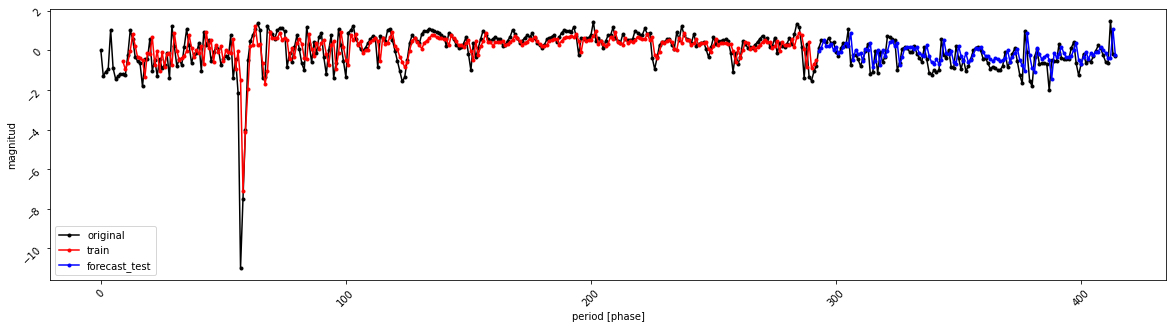

In [59]:
# Solo con AR.
size = (int)(0.7 * df_c.shape[0])
plt.figure(figsize = (20,5))
plt.plot(df_star['mag'], '.-', color = 'black', label = 'original') #.-
plt.plot(df_c['Predicted_Values'][:size], '.-', color = 'red', label = 'train') # 
plt.plot(df_c['Predicted_Values'][size:], '.-', color = 'blue', label = 'forecast_test') #
plt.legend(loc='best')
plt.ylabel('magnitud')
plt.xlabel('period [phase]')
# plt.title(str(title))
plt.tick_params(labelrotation=45)
plt.text.usetex = True
plt.savefig(fname = 'exampleserie.svg')
plt.show()

Generating the residuals for MA

In [60]:
res = pd.DataFrame()
res['Residuals'] = df_c.mag - df_c.Predicted_Values
res

,Residuals
9,-0.616962
10,-0.299205
11,0.375827
12,1.030494
13,-0.252920
...,...
410,-0.454249
411,-0.266908
412,1.874697
413,-1.250390


<AxesSubplot:ylabel='Density'>

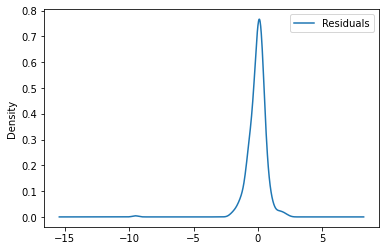

In [61]:
res.plot(kind='kde')

#Step 3 : Fitting MA on Residuals

In [62]:
best_q = train_ma(res)

The RMSE is : 0.6123167870263194 , Value of q :  1
The RMSE is : 0.6127971223996485 , Value of q :  2
The RMSE is : 0.6115142681276831 , Value of q :  3
The RMSE is : 0.610585027378942 , Value of q :  4
The RMSE is : 0.6109002763577639 , Value of q :  5
The RMSE is : 0.6112129417608189 , Value of q :  6
The RMSE is : 0.6112164362144841 , Value of q :  7
The RMSE is : 0.6145763579453706 , Value of q :  8
The RMSE is : 0.6142959298007422 , Value of q :  9
The RMSE is : 0.612644098941149 , Value of q :  10
The RMSE is : 0.6384693989445762 , Value of q :  11
The RMSE is : 0.636497215998372 , Value of q :  12


In [63]:
[res_train,res_test,theta,intercept,RMSE] = MA(best_q,pd.DataFrame(res.Residuals))

The RMSE is : 0.610585027378942 , Value of q :  4


In [64]:
res_c = pd.concat([res_train,res_test])

In [65]:
res_c

,Residuals,Shifted_values_1,Shifted_values_2,Shifted_values_3,Shifted_values_4,Predicted_Values
13,-0.252920,1.030494,0.375827,-0.299205,-0.616962,0.009591
14,-0.564499,-0.252920,1.030494,0.375827,-0.299205,0.010958
15,-0.203437,-0.564499,-0.252920,1.030494,0.375827,0.000362
16,-0.254369,-0.203437,-0.564499,-0.252920,1.030494,-0.025966
17,-1.315459,-0.254369,-0.203437,-0.564499,-0.252920,-0.021331
...,...,...,...,...,...,...
410,-0.454249,-0.252637,-0.078254,0.318802,0.060401,-0.005019
411,-0.266908,-0.454249,-0.252637,-0.078254,0.318802,-0.018577
412,1.874697,-0.266908,-0.454249,-0.252637,-0.078254,-0.019546
413,-1.250390,1.874697,-0.266908,-0.454249,-0.252637,0.008522


In [66]:
df_c.Predicted_Values += res_c.Predicted_Values

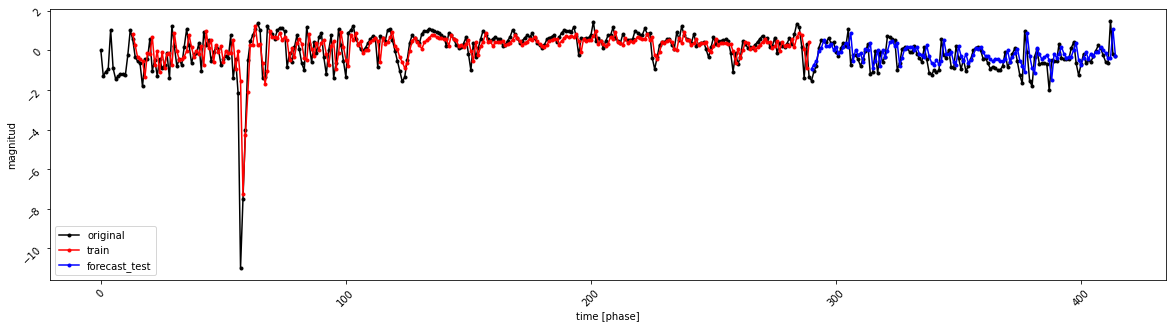

In [67]:
plt.figure(figsize = (20,5))
plt.plot(df_star['mag'], '.-', color = 'black', label = 'original') #.-
plt.plot(df_c['Predicted_Values'][:len(df_train['mag'])], '.-', color = 'red', label = 'train') # 
plt.plot(df_c['Predicted_Values'][len(df_train['mag']):], '.-', color = 'blue', label = 'forecast_test') #
plt.legend(loc='best')
plt.ylabel('magnitud')
plt.xlabel('time [phase]')
# plt.title(str(title))
plt.tick_params(labelrotation=45)
plt.text.usetex = True
plt.savefig(fname = 'exampleserie.svg')
plt.show()